# Temperature Profile
This looks at a single coordinate, evaluating whether the temperature profile is near moist adiabatic for hottest individual days, or averaged over longer e.g. week.

In [22]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.papers.byrne_2021 import get_quant_ind
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load in data
First load in the temperature profile. Then load in the surface pressure, and compute REFHT variables.

Also, compute the LCL, and lapse rates below and above this.

In [3]:
exp_dir = '/Users/joshduffield/Desktop/'
exp_names = ['russia', 'spain', 'australia']
n_exp = len(exp_names)
ds = [xr.load_dataset(os.path.join(exp_dir, exp_names[i]+'.nd2')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.Variable("loc", exp_names))
ds = ds.rename_vars({'TREFHT': 'TS', 'QREFHT': 'QS'})           # rename 2m variables as surface

In [4]:
# Resample as n-day avg data
n_resample = 1
if n_resample > 1:
    ds = ds.resample(time=f"{n_resample}D").mean()

In [5]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['PHIS']]
z2m = []
for i in range(n_exp):
    z2m.append(float(invariant_data.PHIS.sel(lat=ds.isel(loc=i).lat, lon=ds.isel(loc=i).lon, method='nearest')/g + 2))
ds['ZS'] = xr.DataArray(z2m, dims=["loc"], coords={"loc": exp_names}, name="z2m")

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0).load(), ds.hybm.isel(time=0).load(), float(ds.P0.isel(time=0))
ds['hyam'], ds['hybm'], p0 = get_lev_info()

In [6]:
refht_level_index = -3
# refht_level_index = None
ds['p'] = isca_tools.cesm.get_pressure(ds.PS, p0, ds['hyam'], ds['hybm'])
if refht_level_index is not None:
    ds['TREFHT'] = ds.T.isel(lev=refht_level_index)
    ds['QREFHT'] = ds.Q.isel(lev=refht_level_index)
    ds['PREFHT'] = ds.p.isel(lev=refht_level_index)
    ds['ZREFHT'] = ds.Z3.isel(lev=refht_level_index)
else:
    ds['TREFHT'] = ds.TS
    ds['QREFHT'] = ds.QS
    ds['PREFHT'] = ds.PS
    ds['ZREFHT'] = ds.ZS

In [7]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['mse_sat_500'] = moist_static_energy(ds.T500, sphum_sat(ds.T500, pressure_ft), ds.Z500)
ds = ds.load()

In [8]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['lev']],
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def moist_profile(temp_ft, p_ft, p):
    # if np.isnan(temp_ft):
    #     return temp_ft * p          # if not land return numpy array of nans of same length as p
    # takes 5 mins
    # Follows moist adiabat from p_ft to p_lcl then follows constant lapse to surface
    temp_profile = moist_profile(float(temp_ft), float(p_ft), p)
    # temp_at_lcl = interp_hybrid_to_pressure(xr.DataArray(temp_profile, dims='lev', coords={'lev': hybm.lev}),
    #                                         p_surf, hyam, hybm, p0, np.atleast_1d(p_lcl)).isel(plev=0)
    # lapse_below_lcl = float(get_bulk_lapse_rate(temp_refht, temp_at_lcl, p_refht, p_lcl)) * 1000
    # temp_profile[p>=p_lcl] = reconstruct_temp(float(temp_at_lcl), p[p>=p_lcl], p[p>=p_lcl], p_lcl,
    #                                           lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PREFHT)
ds['T_conv_neutral'] = apply_func_vec(conv_neutral_profile, ds.p, ds.T_lcl, ds.p_lcl)


# Compute constant lapse rate profile
ds_use = interp_var_at_pressure(ds.T, ds.p_lcl, ds.PS,
                                ds.hyam, ds.hybm, p0)
ds['T_at_lcl'] = ds_use.T
ds['p_at_lcl'] = ds_use.plev.transpose()
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT,
                                            ds.p_at_lcl) * 1000
ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T500.isel(plev=0), ds.p_at_lcl, float(ds.plev)) * 1000
ds['T_const_lapse'] = apply_func_vec(const_lapse_lcl_profile, ds.p, ds.TREFHT, ds.PREFHT, ds.T_at_lcl,
                                     ds.p_at_lcl, ds.lapse_below_lcl, ds.lapse_above_lcl)
ds = ds.load()

In [25]:
# Only interested between REFHT and 500hPa, so only use certain levels
if ds.lev.min()<10:          # If have not already done lev slicing, do it here
    lev_use = {'min': int(np.abs(ds.p-pressure_ft).where(ds.p<=pressure_ft).argmin(dim='lev').min())}
    lev_use['min'] -= 3     # go a bit above the 500hPa
    if refht_level_index is None or refht_level_index == -1:
        lev_use['max'] = ds.lev.size
    else:
        lev_use['max'] = refht_level_index + 1           # don't want to go below our REFHT
    ds = ds.isel(lev=slice(lev_use['min'], lev_use['max']))

### Example Temperature Profiles for hottest days
Below, I plot the temperature profiles for the hottest days for a given region, and compare against SQE and constant lapse profiles.

In [26]:
quant = 95
quant_mask = get_quant_ind(ds.TREFHT, quant, 0, np.inf,
                           return_mask=True, av_dim='time')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

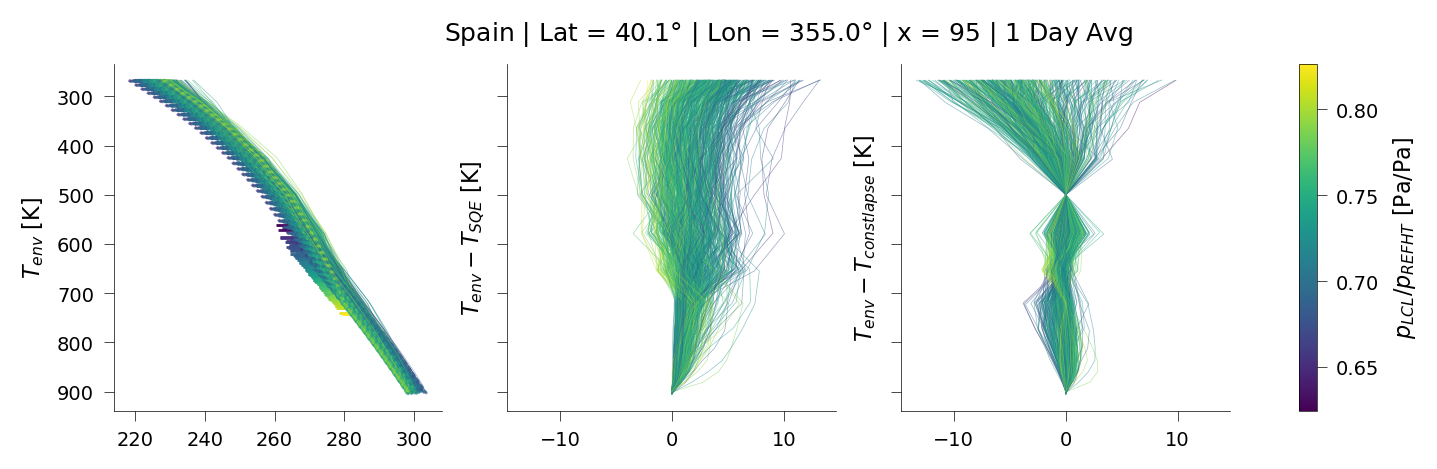

In [197]:
loc_plot = 'spain'
ds_use = ds.sel(loc=loc_plot).where(quant_mask.sel(loc=loc_plot), drop=True)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=(ds_use.p_lcl/ds_use.PREFHT).min(), vmax=(ds_use.p_lcl/ds_use.PREFHT).max())
fig, ax = plt.subplots(1, 3, sharey=True)
isca_tools.plot.fig_resize(fig, 9)
for i in range(ds_use.time.size):
    # if i not in [234, 276]:
    #     continue
    # if (ds_use.mse_REFHT - ds_use.mse_sat_500).isel(time=i) > -11:
    #     continue
    ax[0].plot(ds_use.T.isel(time=i), ds_use.p.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])), lw=ax_linewidth, alpha=0.5)
    # ax[0].plot(ds_use.T_conv_neutral.isel(time=i), ds_use.p.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #            lw=1, alpha=0.5, linestyle=':')
    ax[0].scatter(ds_use.T_lcl.isel(time=i), ds_use.p_lcl.isel(time=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
                  marker='_', lw=1, s=60)
    ax[1].plot(ds_use.T.isel(time=i) -ds_use.T_conv_neutral.isel(time=i), ds_use.p.isel(time=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[2].plot(ds_use.T.isel(time=i) - ds_use.T_const_lapse.isel(time=i), ds_use.p.isel(time=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
ax[0].invert_yaxis()
ax[2].sharex(ax[1])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_ylabel('$T_{env}$ [K]')
ax[1].set_ylabel('$T_{env} - T_{SQE}$ [K]')
ax[2].set_ylabel('$T_{env} - T_{const lapse}$ [K]')
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | {n_resample} Day Avg', y=0.98, fontsize=9)
plt.show()

### Temp profile approx error
Below, I compare how good an approximation the SQE and constant lapse profiles by averaging over all pressure levels.

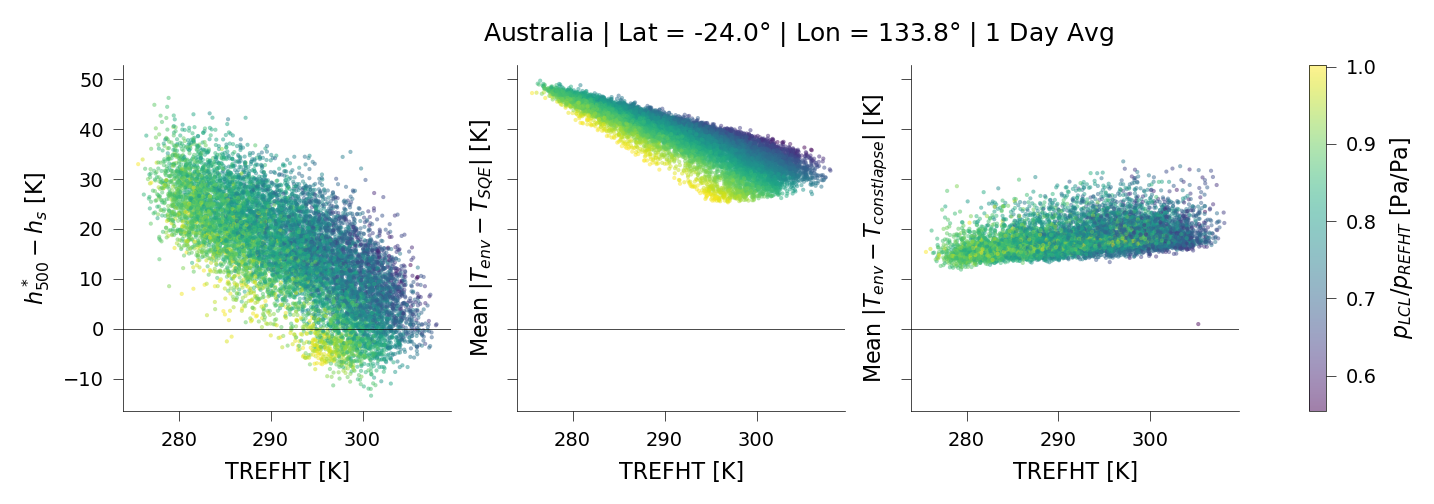

In [35]:
fig, ax = plt.subplots(1, 3, sharey=True)
isca_tools.plot.fig_resize(fig, 9)
ax[0].scatter(ds.sel(loc=loc_plot).TREFHT, -(ds.mse_REFHT-ds.mse_sat_500).sel(loc=loc_plot)*1000/c_p, alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), cmap='viridis', marker='.', s=1)
ax[1].scatter(ds.sel(loc=loc_plot).TREFHT, np.abs(ds.T-ds.T_conv_neutral).sel(loc=loc_plot).mean(dim='lev'), alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), marker='.', s=1)
im = ax[2].scatter(ds.sel(loc=loc_plot).TREFHT, np.abs(ds.T-ds.T_const_lapse).sel(loc=loc_plot).mean(dim='lev'), alpha=0.5,
              c=(ds.p_lcl/ds.PREFHT).sel(loc=loc_plot), marker='.', s=1)
ax[0].set_ylabel('$h_{500}^* - h_s$ [K]')
ax[1].set_ylabel('Mean $|T_{env} - T_{SQE}|$ [K]')
ax[2].set_ylabel('Mean $|T_{env} - T_{const lapse}|$ [K]')
for i in range(n_exp):
    ax[i].axhline(0, lw=ax_linewidth, color='k')
    ax[i].set_xlabel('TREFHT [K]')
plt.colorbar(im, label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ | '
             f'{n_resample} Day Avg',
             y=0.98, fontsize=9)
plt.show()

#### Correlation between simple CAPE and SQE error
Below I show that there is a correlation between the simple CAPE proxy in terms of MSE, and the error in the SQE approximation.

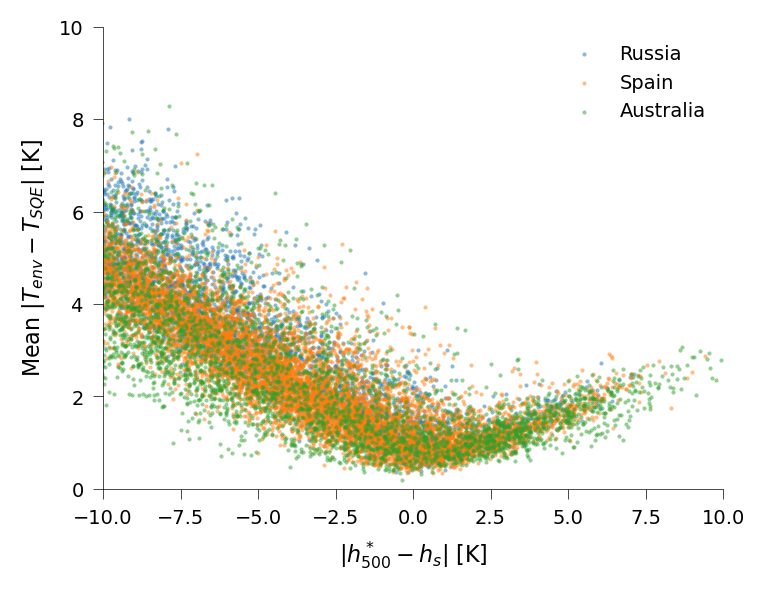

In [42]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 4)
for i in range(ds.lat.size):
    ax.scatter((ds.mse_REFHT-ds.mse_sat_500).isel(loc=i)*1000/c_p, np.abs(ds.T-ds.T_conv_neutral).isel(loc=i).mean(dim='lev'), alpha=0.5,
               color=f"C{i}", label=exp_names[i].capitalize(), marker='.', s=1)
ax.set_xlabel('$|h_{500}^* - h_s|$ [K]')
ax.set_ylabel('Mean $|T_{env} - T_{SQE}|$ [K]')
# ax.set_xlim(0, ax.get_xlim()[1])
# ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(-10, 10)
ax.set_ylim(0, 10)
ax.legend()
plt.show()

## SQE2 Fit
The first SQE fit found the LCL using the formula from the REFHT conditions. Here, we find the LCL level with dry adiabat below and saturated moist adiabat above, such that the mean absolute error between this and the actual temperature profile between the REFHT and 300hPa is minimised.

In [404]:
def get_sqe2_prof(temp_refht, p_refht, temp_lev, p, p_surface, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if 'plev' in p_surface:
        p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p.min()), plev_step, 'floor'),
                                round_any(float(p.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = dry_profile_temp(temp_refht, p_refht, plevs_split_all)
    # temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
    #                                            new_levels=plevs_split_all.values, lev_dim='lev')
    # temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    # temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(conv_neutral_profile, p, temp_split_all.isel(p_split=j), plevs_split_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    # Only include p_split levels where in between refht and FT
    T_prof_all = T_prof_all.where(T_prof_all.p_split <= p_refht)

    # Find level which minimises error between actual profile and constant lapse profile
    ind_split_best = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev').fillna(np.inf).argmin(dim='p_split').astype(int)
    # lev_split_best = argmin_with_nan
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best)
    p_split = plevs_split_all.isel(p_split=ind_split_best).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best).where(temp_refht>0)
    return temp_prof_best, p_split, temp_split


def get_best_lev_split_prof(temp_refht, p_refht, temp_ft, p_ft, temp_lev, p, p_surface, hyam, hybm, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if 'plev' in p_surface:
        p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p.min()), plev_step, 'floor'),
                                round_any(float(p.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    # error_mode is way to quantify error between actual profile and constant lapse profile across all levels
    lapse_below_all = get_bulk_lapse_rate(temp_refht, temp_split_all, p_refht,
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims})) * 1000
    lapse_above_all = get_bulk_lapse_rate(temp_split_all, temp_ft,
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims}), p_ft) * 1000
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(const_lapse_lcl_profile, p, temp_refht, p_refht, temp_split_all.isel(p_split=j),
                                         plevs_split_all.isel(p_split=j), lapse_below_all.isel(p_split=j), lapse_above_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    # Only include p_split levels where in between refht and FT
    T_prof_all = T_prof_all.where(T_prof_all.p_split <= p_refht)
    T_prof_all = T_prof_all.where(T_prof_all.p_split >= p_ft)

    # Find level which minimises error between actual profile and constant lapse profile
    ind_split_best = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev').fillna(np.inf).argmin(dim='p_split').astype(int)
    # lev_split_best = argmin_with_nan
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best, drop=True)
    p_split = plevs_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)
    return temp_prof_best, p_split, temp_split

In [211]:
loc_plot = 'russia'
ds_hot = [ds.isel(loc=i).where(quant_mask.isel(loc=i), drop=True) for i in range(n_exp)]
n_sample = ds_hot[0].time.size
for i in range(n_exp):
    ds_hot[i] = ds_hot[i].rename({'time': 'sample'}).assign_coords({'sample': np.arange(n_sample)})
ds_hot = xr.concat(ds_hot, dim='loc')

In [216]:
ds_hot['T_conv_neutral2'], ds_hot['p_lcl2'], ds_hot['T_lcl2'] = get_sqe2_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T, ds_hot.p, ds_hot.PS)
ds_hot = ds_hot.drop_vars('p_split')

In [464]:
ds_hot['T_const_lapse_best'], ds_hot['const_lapse_best_p_split'], ds_hot['const_lapse_best_temp_split'] = \
    get_best_lev_split_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T500.isel(plev=0), float(ds_hot.plev),
                            ds_hot.T, ds_hot.p, ds_hot.PS, ds_hot.hyam, ds_hot.hybm)
ds_hot = ds_hot.drop_vars('p_split')

### LCL vs CAPE relation
Below we see that the optimal LCL, $p_{LCL2}$ is closer to (further from) the surface when the CAPE proxy is negative (positive) indicating more moist (dry) conditions than may be expected from the REFHT conditions.

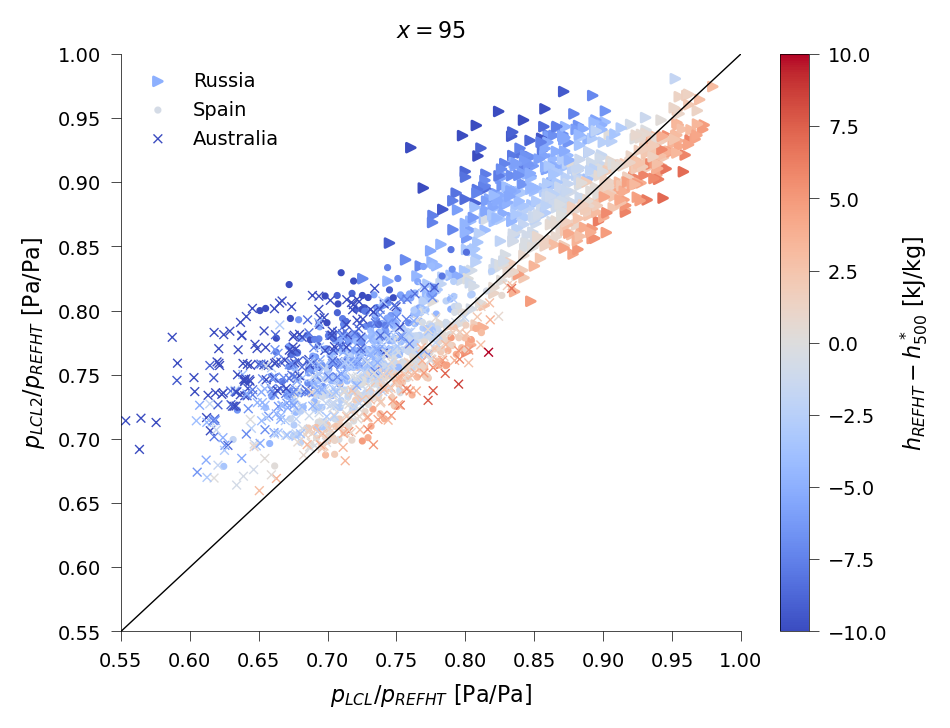

In [337]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
for i in range(n_exp):
    im = ax.scatter((ds_hot.p_lcl/ds_hot.PREFHT).isel(loc=i), (ds_hot.p_lcl2/ds_hot.PREFHT).isel(loc=i),
                c=(ds_hot.mse_REFHT-ds_hot.mse_sat_500).isel(loc=i), cmap='coolwarm', vmin=-10, vmax=10, marker=['>', '.', 'x'][i], s=10,
               label=exp_names[i].capitalize())
ax.legend()
ax.plot([0.55, 1], [0.55, 1], color='k')
ax.set_xlabel("$p_{LCL}/p_{REFHT}$ [Pa/Pa]")
ax.set_ylabel("$p_{LCL2}/p_{REFHT}$ [Pa/Pa]")
plt.colorbar(im, ax=ax, label='$h_{REFHT} - h_{500}^*$ [kJ/kg]')
ax.set_xlim(0.55, 1)
ax.set_ylim(0.55, 1)
ax.set_title(f'$x={quant}$')
plt.show()

### Better temperature profile fit for SQE2
Below we see that SQE2 is the same as SQE below the LCL. But the $T_{env} - T_{SQE2}$ plot looks more like we would expect in a convective regime: CIN below LCL with $T_{env} > T_{SQE2}$ and CAPE above LCL, with $T_{env} < T_{SQE2}$. Then at very high altitudes, $T_{env} > T_{SQE2}$ again, as we are above the LZB.

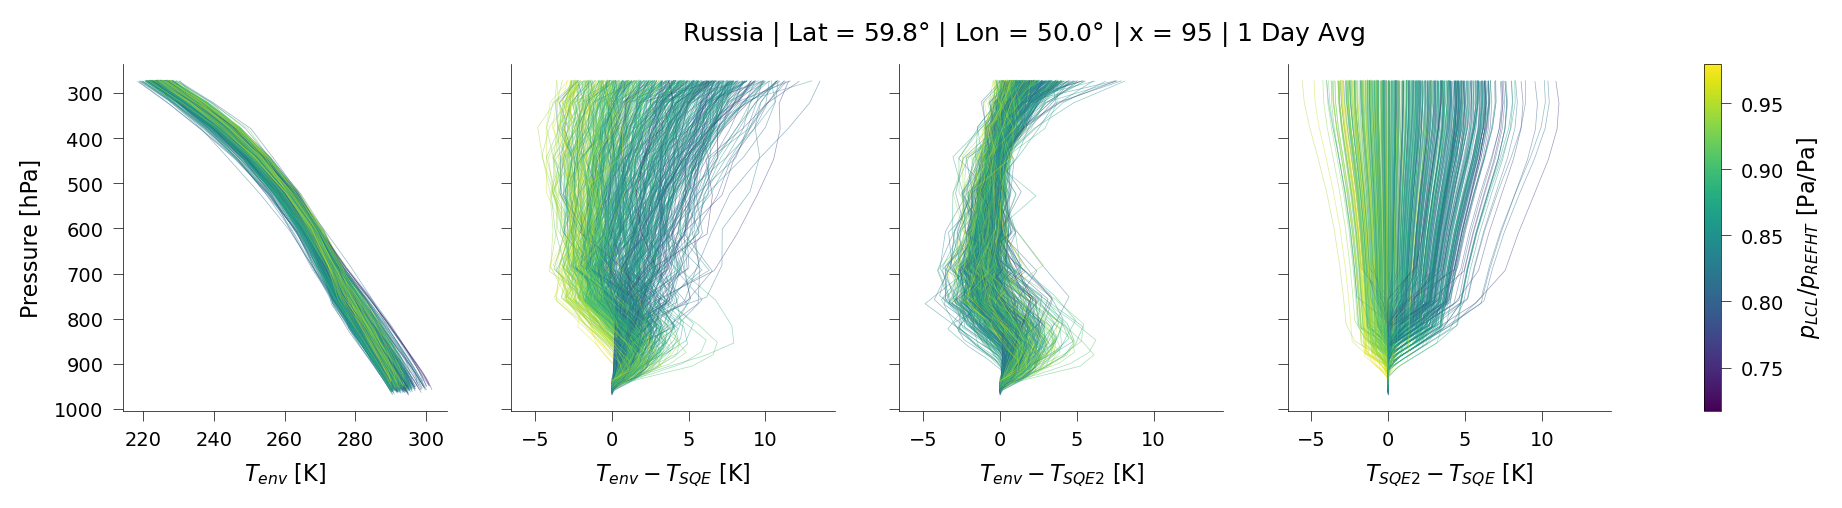

In [480]:
loc_plot = 'russia'
ds_use = ds_hot.sel(loc=loc_plot)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=(ds_use.p_lcl/ds_use.PREFHT).min(), vmax=(ds_use.p_lcl/ds_use.PREFHT).max())
fig, ax = plt.subplots(1, 4, sharey=True)
isca_tools.plot.fig_resize(fig, 12)
for i in range(n_sample):
    # if i not in [234, 276]:
    #     continue
    # if (ds_use.mse_REFHT - ds_use.mse_sat_500).isel(sample=i) < 4:
    #     continue
    ax[0].plot(ds_use.T.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])), lw=ax_linewidth, alpha=0.5)
    # ax[0].plot(ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #            lw=1, alpha=0.5, linestyle=':')
    # ax[0].scatter(ds_use.T_lcl.isel(sample=i), ds_use.p_lcl.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #               marker='_', lw=1, s=60)
    ax[1].plot(ds_use.T.isel(sample=i) -ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[2].plot(ds_use.T.isel(sample=i) - ds_use.T_conv_neutral2.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[3].plot(ds_use.T_conv_neutral2.isel(sample=i) - ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
ax[0].invert_yaxis()
ax[2].sharex(ax[1])
ax[3].sharex(ax[1])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$T_{env}$ [K]')
ax[1].set_xlabel('$T_{env} - T_{SQE}$ [K]')
ax[2].set_xlabel('$T_{env} - T_{SQE2}$ [K]')
ax[3].set_xlabel('$T_{SQE2} - T_{SQE}$ [K]')
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | {n_resample} Day Avg', y=0.98, fontsize=9)
plt.show()

### Error reduction by SQE2
Below, we see that (by design) SQE2 always has less error than SQE, and also on average has less error than the constant lapse rate method. We also see that we get a bigger error reduction, the larger tha absolute value of the CAPE proxy, as might be expected from the LCL effect.

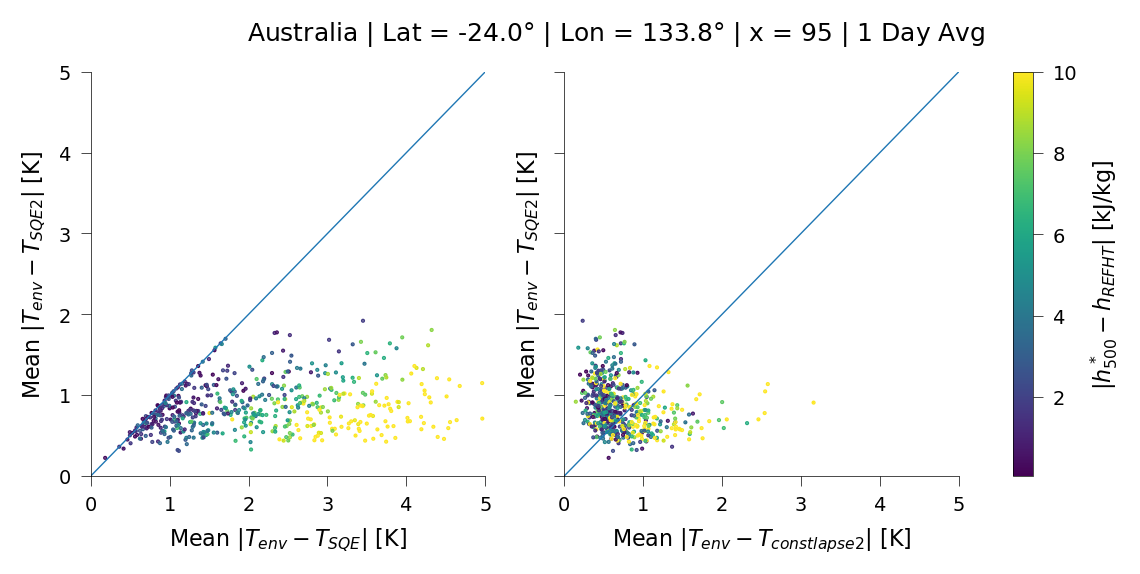

In [483]:
loc_plot = 'australia'
ds_use = ds_hot.sel(loc=loc_plot)
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 7)
ax[0].scatter(np.abs(ds_use.T-ds_use.T_conv_neutral).mean(dim='lev'), np.abs(ds_use.T-ds_use.T_conv_neutral2).mean(dim='lev'),
              c=np.abs(ds_use.mse_REFHT-ds_use.mse_sat_500), marker='.', s=1, vmax=10)
im = ax[1].scatter(np.abs(ds_use.T-ds_use.T_const_lapse_best).mean(dim='lev'), np.abs(ds_use.T-ds_use.T_conv_neutral2).mean(dim='lev'),
              c=np.abs(ds_use.mse_REFHT-ds_use.mse_sat_500), marker='.', s=1, vmax=10)
ax[0].set_xlabel('Mean $|T_{env} - T_{SQE}|$ [K]')
ax[1].set_xlabel('Mean $|T_{env} - T_{constlapse2}|$ [K]')
for i in range(2):
    ax[i].plot([0, 5], [0, 5])
    ax[i].set_ylabel('Mean $|T_{env} - T_{SQE2}|$ [K]')
plt.colorbar(im, label="$|h_{500}^* - h_{REFHT}|$ [kJ/kg]", ax=ax.ravel())
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, 5)
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ | x = {quant} | '
             f'{n_resample} Day Avg',
             y=0.98, fontsize=9)
plt.show()

#### Timeseries for hottest days
To show that there are sharp changes in LCL, and CAPE proxy, so maybe the temperature profile does not have time to respond to the new REFHT conditions, so does not follow profile expected.

This might explain the link between $p_{LCL2}-p_{LCL}$ and the CAPE proxy.

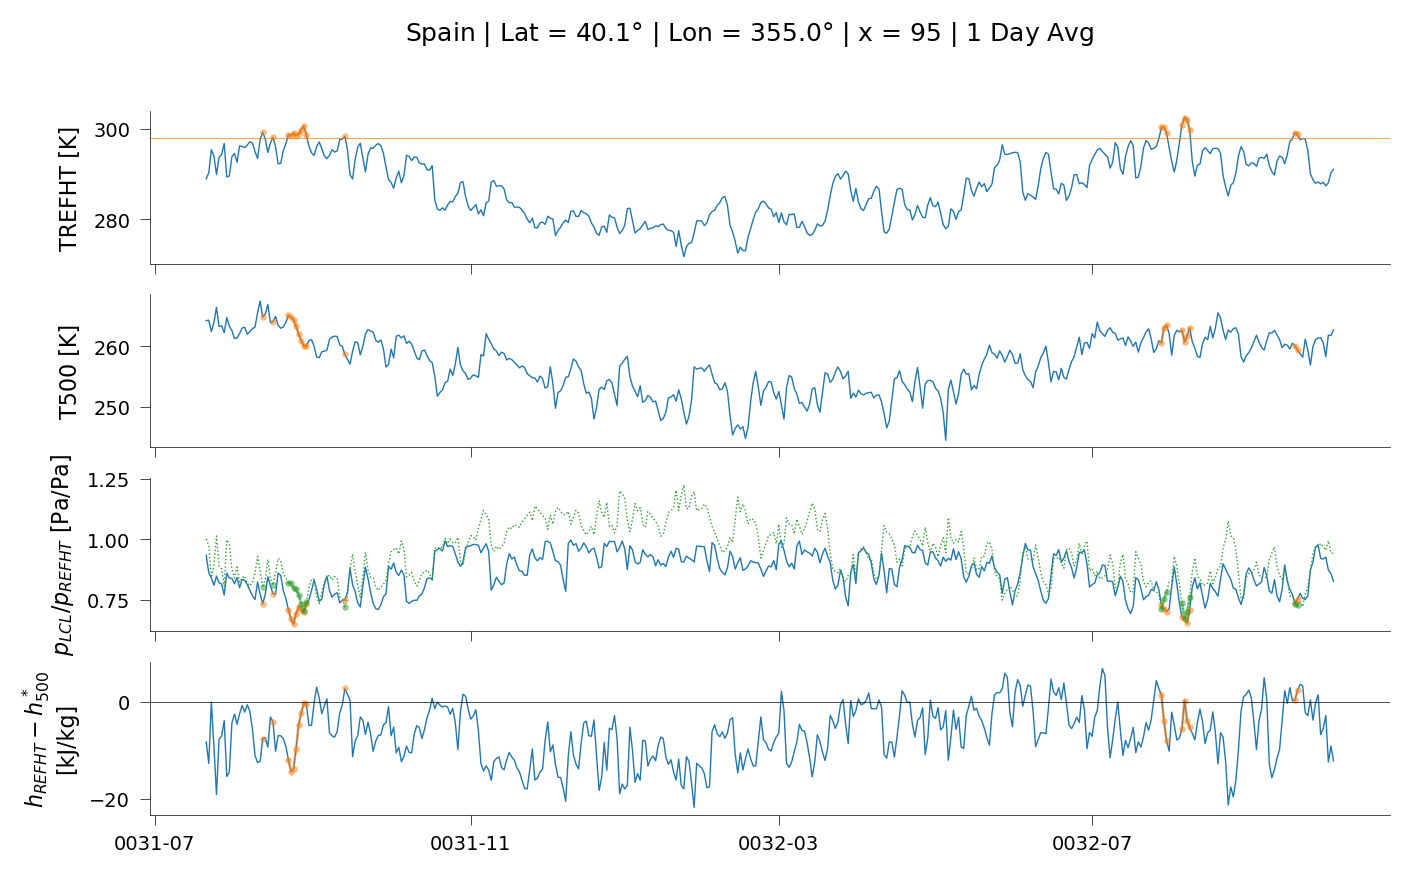

In [503]:
loc_plot = 'spain'
ds_use = ds.sel(loc=loc_plot).isel(time=slice(200, 640))
ds_use['QREFHT3'] = ds_use['QREFHT'] - (ds_use.mse_REFHT - ds_use.mse_sat_500).isel(plev=0) * 1000 / L_v
ds_use['p_lcl3'], ds_use['T_lcl3'] = lcl_metpy(ds_use.TREFHT, ds_use.QREFHT3, ds_use.PREFHT)
# ds_use['T_conv_neutral2'], ds_use['p_lcl2'], ds_use['T_lcl2'] = get_sqe2_prof(ds_use.TREFHT, ds_use.PREFHT, ds_use.T, ds_use.p, ds_use.PS)
ds_use_quant = ds_use.where(quant_mask.sel(loc=loc_plot).isel(time=slice(200, 640)))
fig, ax = plt.subplots(4, 1, sharex=True)
isca_tools.plot.fig_resize(fig, 8, ar=7)
ax[0].plot(ds_use.time, ds_use.TREFHT)
ax[0].plot(ds_use_quant.time, ds_use_quant.TREFHT, lw=1, alpha=0.5, marker='.', markersize=4, color='C1')
ax[0].axhline(ds.where(quant_mask).sel(loc=loc_plot).TREFHT.min(), lw=ax_linewidth, color='C1')
ax[0].set_ylabel('TREFHT [K]')

ax[1].plot(ds_use.time, ds_use.T500)
ax[1].plot(ds_use_quant.time, ds_use_quant.T500, lw=1, alpha=0.5, marker='.', markersize=4, color='C1')
ax[1].set_ylabel('T500 [K]')

ax[2].plot(ds_use.time, ds_use.p_lcl/ds_use.PREFHT)
ax[2].plot(ds_use.time, ds_use.p_lcl3/ds_use.PREFHT, color='C2', linestyle=':')
ax[2].plot(ds_use_quant.time, ds_use_quant.p_lcl/ds_use_quant.PREFHT, lw=1, alpha=0.5, marker='.', markersize=4, color='C1')
ax[2].plot(ds_use_quant.time, ds_use_quant.p_lcl3/ds_use_quant.PREFHT, lw=1, alpha=0.5, marker='.', markersize=4, color='C2')
ax[2].set_ylabel('$p_{LCL}/p_{REFHT}$ [Pa/Pa]')

ax[3].plot(ds_use.time, ds_use.mse_REFHT - ds_use.mse_sat_500)
ax[3].plot(ds_use_quant.time, ds_use_quant.mse_REFHT - ds_use_quant.mse_sat_500, lw=1, alpha=0.5, marker='.', markersize=4, color='C1')
ax[3].axhline(0, color='k', lw=ax_linewidth)
ax[3].set_ylabel('$h_{REFHT}-h^*_{500}$\n[kJ/kg]')
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | {n_resample} Day Avg', y=0.98, fontsize=9)
plt.show()

## SQE3
Rather than finding the LCL to minimize the error, it is easier to just find the LCL such that the CAPE proxy is zero. That is what we do here, and show that it gives very similar results to SQE2.

In [422]:
ds_hot['QREFHT3'] = ds_hot['QREFHT'] - (ds_hot.mse_REFHT - ds_hot.mse_sat_500).isel(plev=0) * 1000 / L_v
ds_hot['p_lcl3'], ds_hot['T_lcl3'] = lcl_metpy(ds_hot.TREFHT, ds_hot.QREFHT3, ds_hot.PREFHT)
ds_hot['T_conv_neutral3'] = apply_func_vec(conv_neutral_profile, ds_hot.p, ds_hot.T_lcl3, ds_hot.p_lcl3)

In [434]:
# Sanity check that with QREFHT3, there is no CAPE
float(np.abs(moist_static_energy(ds_hot.TREFHT, ds_hot.QREFHT3, ds_hot.ZREFHT) - ds_hot.mse_sat_500.isel(plev=0)).max())

4.359683396160108e-05

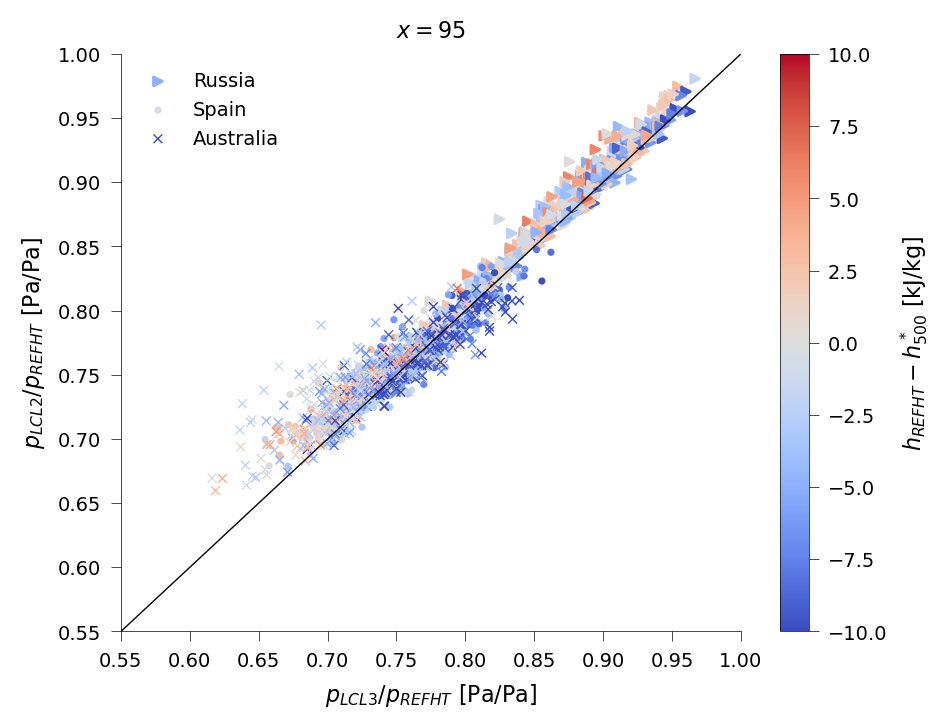

In [441]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
for i in range(n_exp):
    im = ax.scatter((ds_hot.p_lcl3/ds_hot.PREFHT).isel(loc=i), (ds_hot.p_lcl2/ds_hot.PREFHT).isel(loc=i),
                c=(ds_hot.mse_REFHT-ds_hot.mse_sat_500).isel(loc=i), cmap='coolwarm', vmin=-10, vmax=10, marker=['>', '.', 'x'][i], s=10,
               label=exp_names[i].capitalize())
ax.legend()
ax.plot([0.55, 1], [0.55, 1], color='k')
ax.set_xlabel("$p_{LCL3}/p_{REFHT}$ [Pa/Pa]")
ax.set_ylabel("$p_{LCL2}/p_{REFHT}$ [Pa/Pa]")
plt.colorbar(im, ax=ax, label='$h_{REFHT} - h_{500}^*$ [kJ/kg]')
ax.set_xlim(0.55, 1)
ax.set_ylim(0.55, 1)
ax.set_title(f'$x={quant}$')
plt.show()

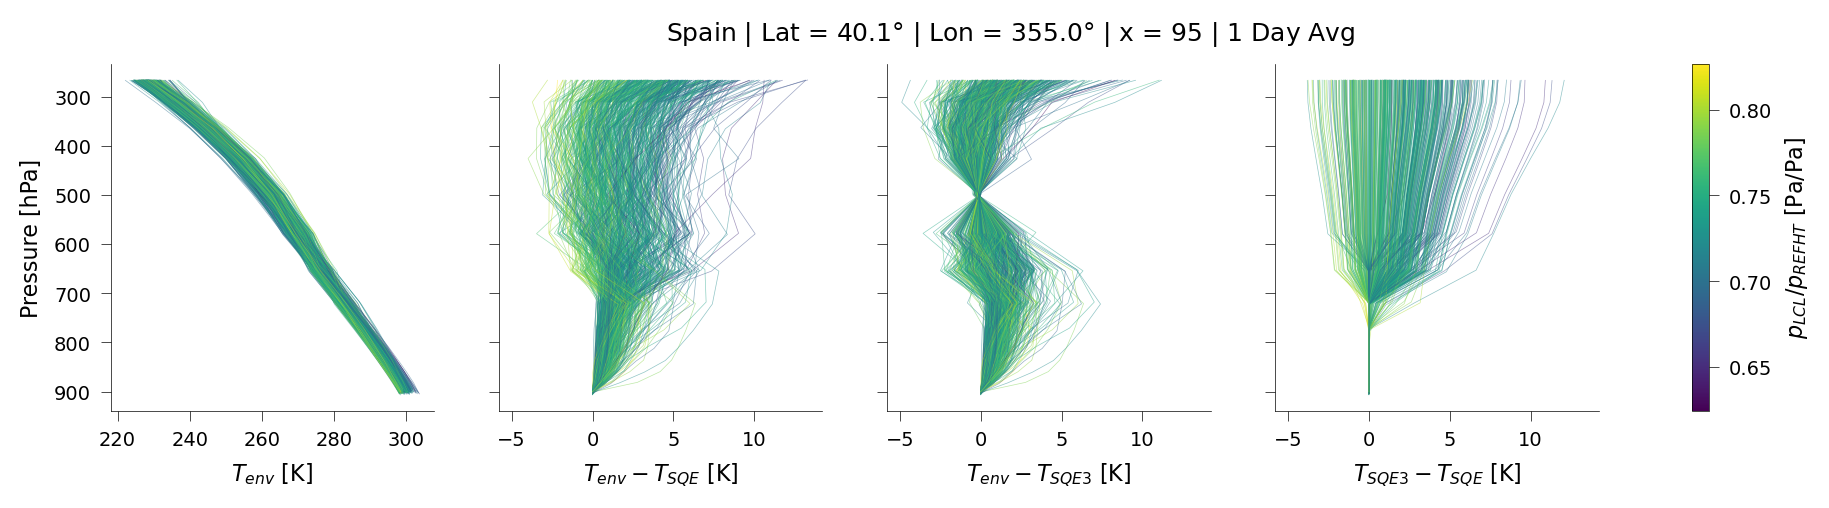

In [459]:
loc_plot = 'spain'
ds_use = ds_hot.sel(loc=loc_plot)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=(ds_use.p_lcl/ds_use.PREFHT).min(), vmax=(ds_use.p_lcl/ds_use.PREFHT).max())
fig, ax = plt.subplots(1, 4, sharey=True)
isca_tools.plot.fig_resize(fig, 12)
for i in range(n_sample):
    # if i not in [234, 276]:
    #     continue
    # if (ds_use.mse_REFHT - ds_use.mse_sat_500).isel(sample=i) > -11:
    #     continue
    ax[0].plot(ds_use.T.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])), lw=ax_linewidth, alpha=0.5)
    # ax[0].plot(ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #            lw=1, alpha=0.5, linestyle=':')
    # ax[0].scatter(ds_use.T_lcl.isel(sample=i), ds_use.p_lcl.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #               marker='_', lw=1, s=60)
    ax[1].plot(ds_use.T.isel(sample=i) -ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[2].plot(ds_use.T.isel(sample=i) - ds_use.T_conv_neutral3.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[3].plot(ds_use.T_conv_neutral3.isel(sample=i) - ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
ax[0].invert_yaxis()
ax[2].sharex(ax[1])
ax[3].sharex(ax[1])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$T_{env}$ [K]')
ax[1].set_xlabel('$T_{env} - T_{SQE}$ [K]')
ax[2].set_xlabel('$T_{env} - T_{SQE3}$ [K]')
ax[3].set_xlabel('$T_{SQE3} - T_{SQE}$ [K]')
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | {n_resample} Day Avg', y=0.98, fontsize=9)
plt.show()

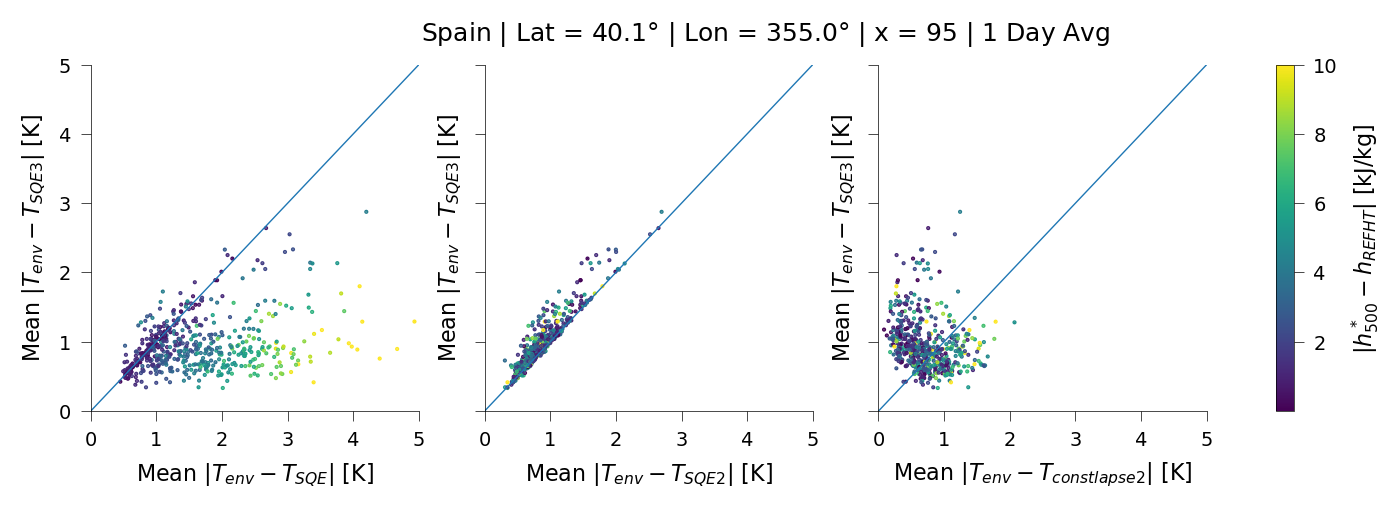

In [461]:
ds_use = ds_hot.sel(loc=loc_plot)
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 9)
ax[0].scatter(np.abs(ds_use.T-ds_use.T_conv_neutral).mean(dim='lev'), np.abs(ds_use.T-ds_use.T_conv_neutral3).mean(dim='lev'),
              c=np.abs(ds_use.mse_REFHT-ds_use.mse_sat_500), marker='.', s=1, vmax=10)
ax[1].scatter(np.abs(ds_use.T-ds_use.T_conv_neutral2).mean(dim='lev'), np.abs(ds_use.T-ds_use.T_conv_neutral3).mean(dim='lev'),
              c=np.abs(ds_use.mse_REFHT-ds_use.mse_sat_500), marker='.', s=1, vmax=10)
im = ax[2].scatter(np.abs(ds_use.T-ds_use.T_const_lapse_best).mean(dim='lev'), np.abs(ds_use.T-ds_use.T_conv_neutral3).mean(dim='lev'),
              c=np.abs(ds_use.mse_REFHT-ds_use.mse_sat_500), marker='.', s=1, vmax=10)
ax[0].set_xlabel('Mean $|T_{env} - T_{SQE}|$ [K]')
ax[1].set_xlabel('Mean $|T_{env} - T_{SQE2}|$ [K]')
ax[2].set_xlabel('Mean $|T_{env} - T_{constlapse2}|$ [K]')
for i in range(3):
    ax[i].plot([0, 5], [0, 5])
    ax[i].set_ylabel('Mean $|T_{env} - T_{SQE3}|$ [K]')
plt.colorbar(im, label="$|h_{500}^* - h_{REFHT}|$ [kJ/kg]", ax=ax.ravel())
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, 5)
fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ | x = {quant} | '
             f'{n_resample} Day Avg',
             y=0.98, fontsize=9)
plt.show()

### Example Temperature profile
Below, we plot the temperature profile and both SQE fits for a given location and time, to show that SQE2 or SQE3 seems better the eye.

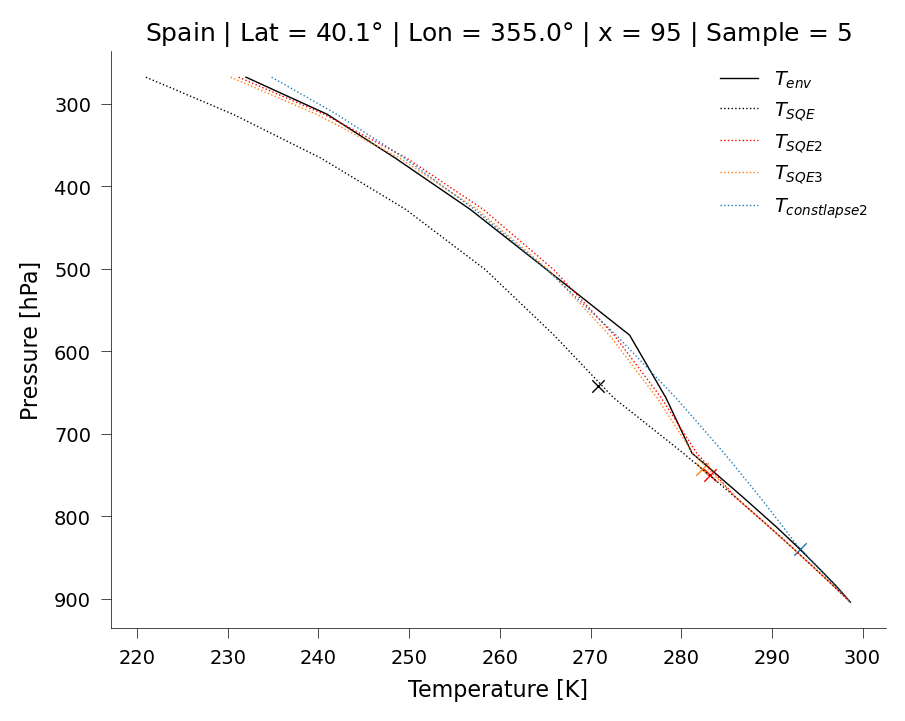

In [504]:
i = 5
loc_plot = 'spain'
ds_use = ds_hot.isel(sample=i).sel(loc=loc_plot)
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
ax.plot(ds_use.T, ds_use.p/100, color='k', label='$T_{env}$')
ax.plot(ds_use.T_conv_neutral, ds_use.p/100, linestyle=':', color='k', label='$T_{SQE}$')
ax.scatter(ds_use.T_lcl, ds_use.p_lcl/100, marker='x', color='k', s=20)
ax.plot(ds_use.T_conv_neutral2, ds_use.p/100, linestyle=':', color='r', label='$T_{SQE2}$')
ax.scatter(ds_use.T_lcl2, ds_use.p_lcl2/100, marker='x', color='r', s=20)
ax.plot(ds_use.T_conv_neutral3, ds_use.p/100, linestyle=':', color='C1', label='$T_{SQE3}$')
ax.scatter(ds_use.T_lcl3, ds_use.p_lcl3/100, marker='x', color='C1', s=20)
ax.plot(ds_use.T_const_lapse_best, ds_use.p/100, linestyle=':', color='C0', label='$T_{constlapse2}$')
ax.scatter(ds_use.const_lapse_best_temp_split, ds_use.const_lapse_best_p_split/100, marker='x', color='C0', s=20)
ax.legend()
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Pressure [hPa]")
ax.set_title(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
             f' x = {quant} | Sample = {i}', y=0.99, fontsize=9)
plt.gca().invert_yaxis()

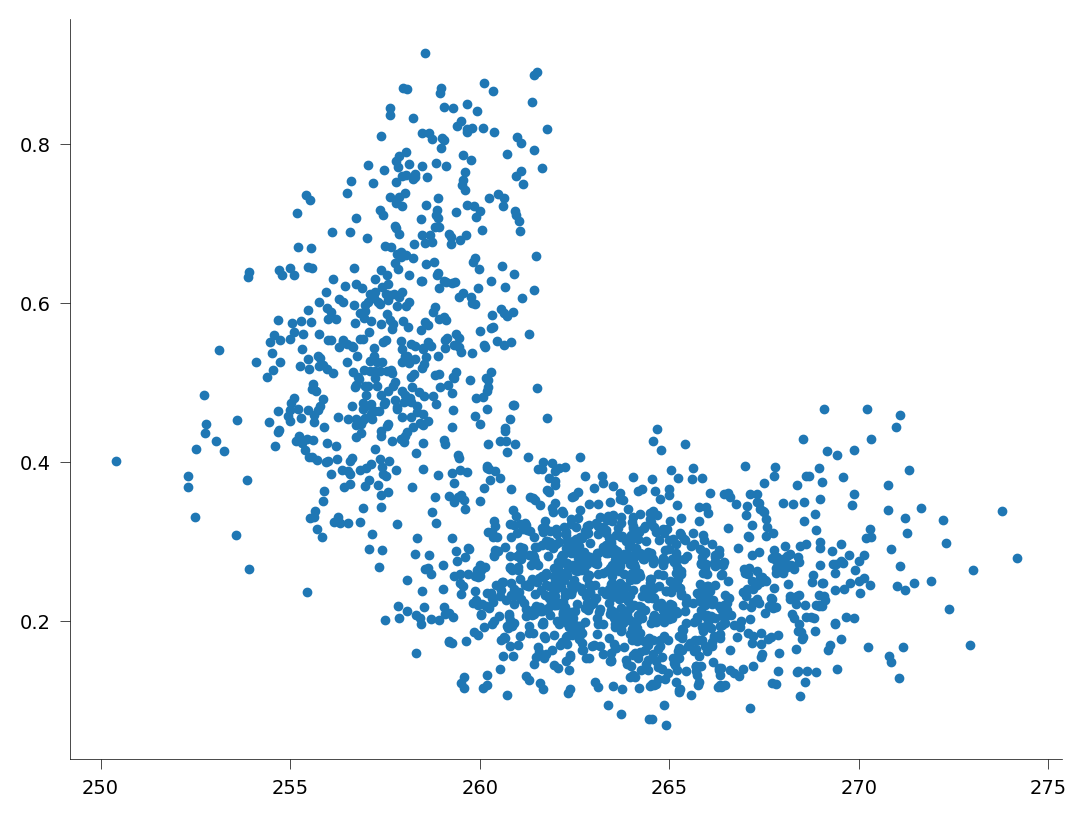

In [505]:
plt.scatter(ds_hot.T500, ds_hot.QREFHT/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT))

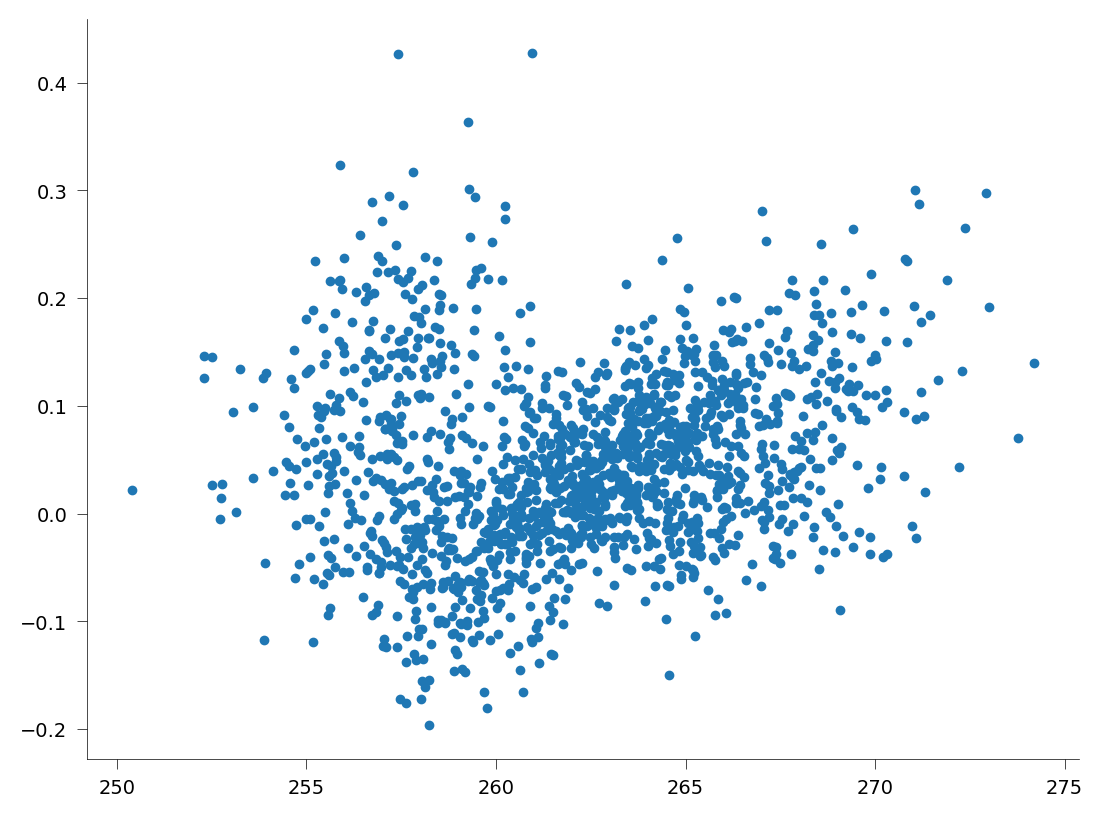

In [506]:
plt.scatter(ds_hot.T500, ds_hot.QREFHT3/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT) - ds_hot.QREFHT/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT))

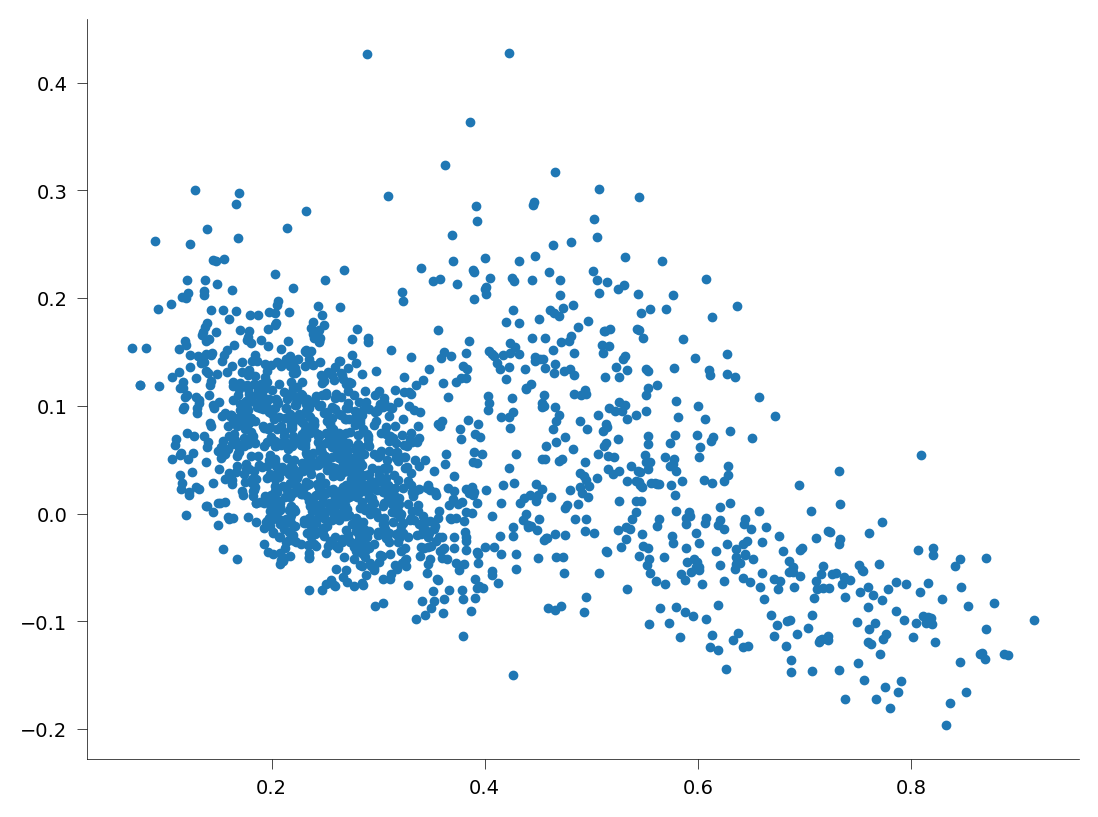

In [507]:
plt.scatter(ds_hot.QREFHT/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT), ds_hot.QREFHT3/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT) - ds_hot.QREFHT/sphum_sat(ds_hot.TREFHT, ds_hot.PREFHT))